In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [17]:
_N = 32
batch_size = 128
n_classes = 43
torch.set_float32_matmul_precision('high')
mean = 0.3211
std = 0.2230
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
from dataset import get_data
PATH,LABELS,normalise,GROUPS,GROUP_NAMES,n_classes,train_loader,test_loader = get_data(_N,batch_size)

In [19]:
def to_image(img): # convert to unormalized form for viewing
    return (img * std + mean).permute(1,2,0).numpy()

In [20]:
groups_to_keep = {2,3,5}
{old : new for new,old in enumerate(groups_to_keep)}

{2: 0, 3: 1, 5: 2}

In [21]:
plt.rc('axes', titlesize=8)

def show_groups(loader):
    plt.figure(figsize=(15,7))
    images = torch.zeros((n_classes,3,_N,_N))

    for imgs,lbls in loader:
        for img,lbl in zip(imgs,lbls):
            images[lbl] = img
    for i, img in enumerate(images):
        plt.subplot(4,11, i + 1)
        plt.imshow(to_image(img))
        plt.title(f"{GROUP_NAMES[GROUPS[i]]}")
        plt.axis("off")
    plt.tight_layout()


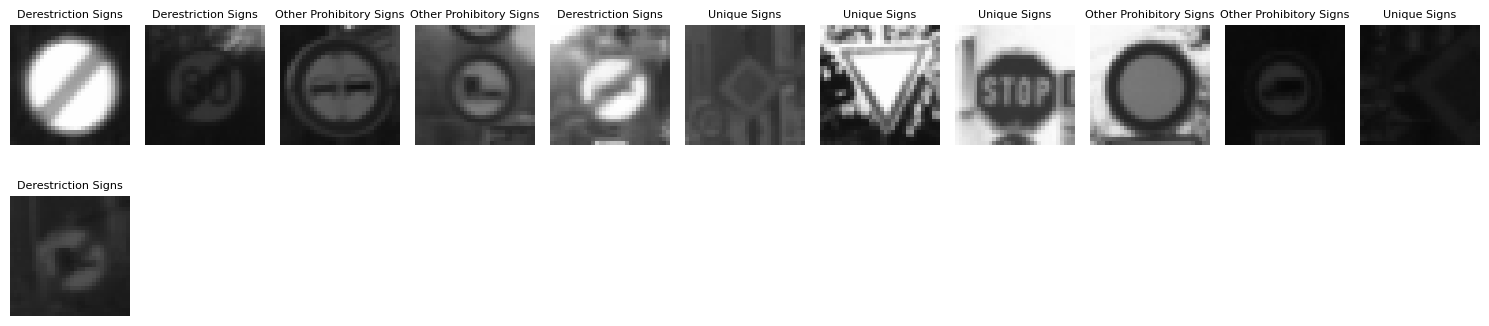

In [22]:
show_groups(train_loader)

In [23]:
GROUP_MATRIX = [[group == i for group in GROUPS] for i in range(3)]

print(",\n".join(map(str,GROUP_MATRIX)))

GROUP_NAMES

[False, False, False, False, False, True, True, True, False, False, True, False],
[True, True, False, False, True, False, False, False, False, False, False, True],
[False, False, True, True, False, False, False, False, True, True, False, False]


['Unique Signs', 'Derestriction Signs', 'Other Prohibitory Signs']

In [24]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((batch_size,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)

    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 28, 28]             156
         MaxPool2d-2           [128, 6, 14, 14]               0
            Conv2d-3          [128, 16, 10, 10]           2,416
         MaxPool2d-4            [128, 16, 5, 5]               0
            Linear-5                 [128, 128]          51,328
            Linear-6                  [128, 64]           8,256
            Linear-7                  [128, 12]             780
Total params: 62,936
Trainable params: 62,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 7.89
Params size (MB): 0.24
Estimated Total Size (MB): 8.63
----------------------------------------------------------------


In [25]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [26]:
def train(model,loss_func,optimiser,epochs):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [27]:
train(model,loss_func,optimiser,epochs)

Epoch 1 --- Training Loss 1.860 --- Validation Loss 1.070
Epoch 2 --- Training Loss 0.602 --- Validation Loss 0.333
Epoch 3 --- Training Loss 0.247 --- Validation Loss 0.163
Epoch 4 --- Training Loss 0.147 --- Validation Loss 0.109
Epoch 5 --- Training Loss 0.096 --- Validation Loss 0.086
Epoch 6 --- Training Loss 0.070 --- Validation Loss 0.065
Epoch 7 --- Training Loss 0.051 --- Validation Loss 0.050
Epoch 8 --- Training Loss 0.042 --- Validation Loss 0.034
Epoch 9 --- Training Loss 0.032 --- Validation Loss 0.032
Epoch 10 --- Training Loss 0.025 --- Validation Loss 0.026
Epoch 11 --- Training Loss 0.016 --- Validation Loss 0.028
Epoch 12 --- Training Loss 0.016 --- Validation Loss 0.031
Epoch 13 --- Training Loss 0.016 --- Validation Loss 0.031
Epoch 14 --- Training Loss 0.011 --- Validation Loss 0.027
Epoch 15 --- Training Loss 0.010 --- Validation Loss 0.029
Epoch 16 --- Training Loss 0.009 --- Validation Loss 0.025
Epoch 17 --- Training Loss 0.006 --- Validation Loss 0.033
Epoch 

In [28]:
def save_model(model,name):
    path = f"models/{name}.pth"
    print(f"Saving {path}")
    torch.save(model.state_dict(),path)    
    #inputs = torch.rand((batch_size,1,_N,_N),requires_grad=True).to(device)
    #torch.onnx.export(model,inputs,f"models/{name}.onnx",input_names=["input"],output_names=["output"],dynamic_axes={'input': { 0: 'batch_size' }, 'output': { 0: 'batch_size' }})
save_model(model,"model")

Saving models/model.pth


In [29]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9958
Recall (macro): 0.9958
F1-score (macro): 0.9958


In [30]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(decay_rate,1,iterations,2)
    decay = decay / decay[0]
    decay *= learning_rate
    
    momentum = torch.zeros(images.shape).to(device)

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations + momentum) * alpha

        momentum = momentum * momentum_decay + (1 - momentum_decay) * perturbations

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)



normalise.to(device)

@torch.compile
def denormalise(images):
    return images * std + mean


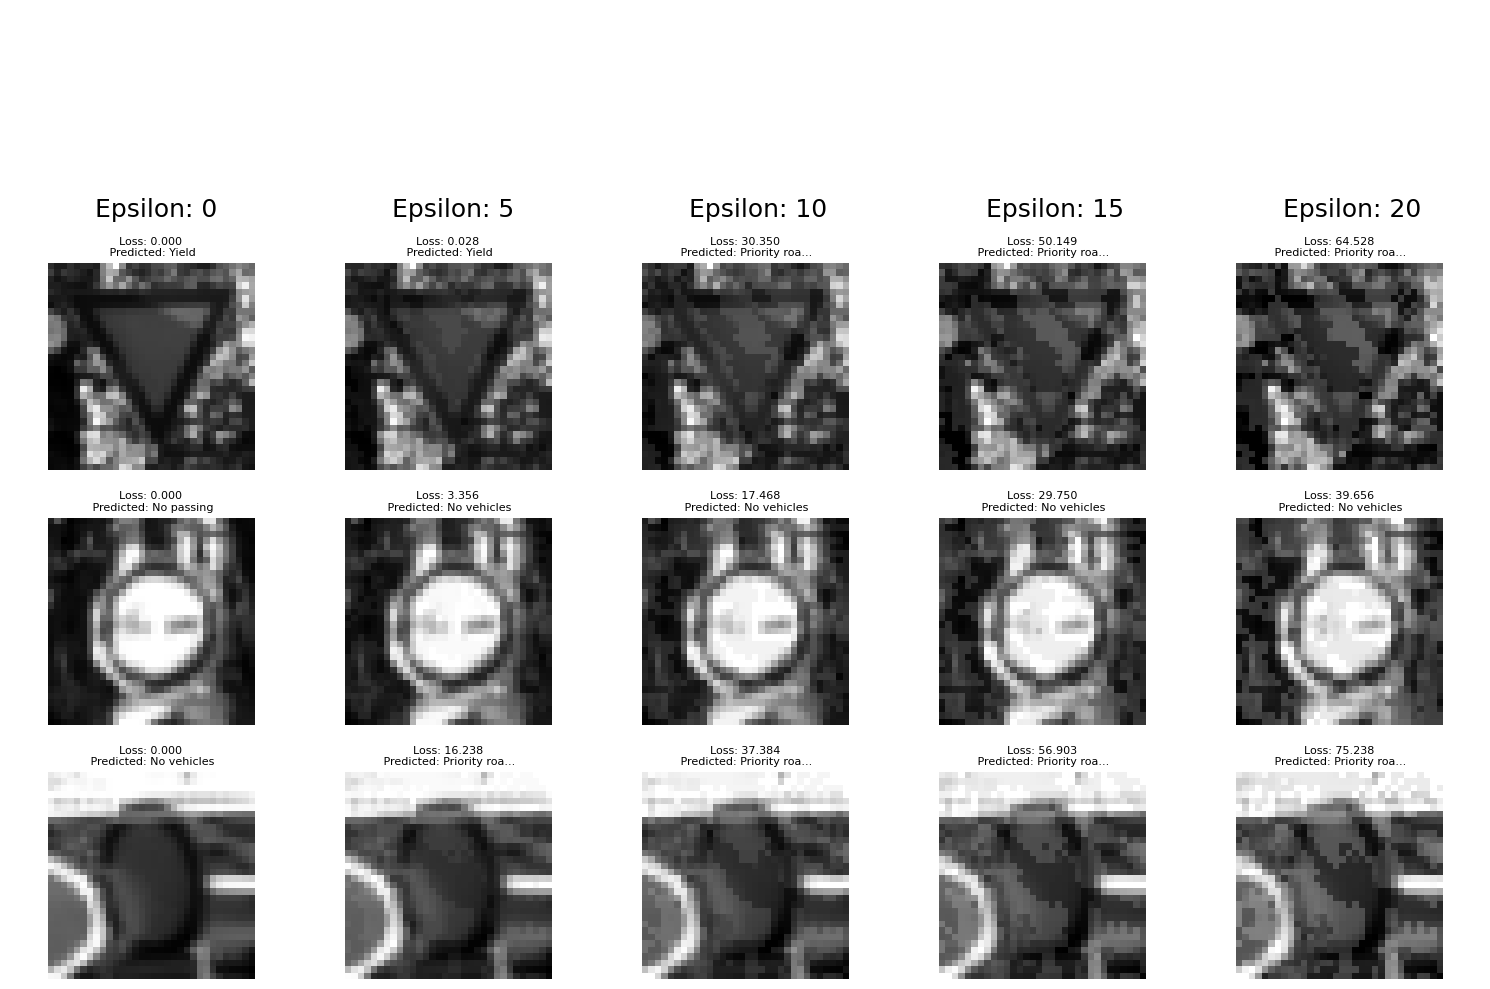

In [31]:
def adversarial_test(model):
    for img,lbl in train_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        rows = 4
        columns = 5
        decay_rate = 6
        learning_rate = 40 / 255
        momentum_decay = 0.8
        iterations = 40
        epsilon = 0.078
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,1,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()),cmap="grey")
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [32]:
def adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [49]:
adversarial_model = Model().to(device)
adv_optimiser = torch.optim.Adam(adversarial_model.parameters())#torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [51]:
decay_rate = 6
learning_rate = 40 / 255
momentum_decay = 0.8
iterations = 40
epsilon = 10 / 255
epochs = 15
adversarial_training(adversarial_model,loss_func,adv_optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay)

Epoch 1 --- Training Loss 0.652 --- Validation Loss 0.244
Epoch 2 --- Training Loss 0.649 --- Validation Loss 0.246
Epoch 3 --- Training Loss 0.639 --- Validation Loss 0.235
Epoch 4 --- Training Loss 0.629 --- Validation Loss 0.247
Epoch 5 --- Training Loss 0.618 --- Validation Loss 0.239
Epoch 6 --- Training Loss 0.616 --- Validation Loss 0.221
Epoch 7 --- Training Loss 0.616 --- Validation Loss 0.232
Epoch 8 --- Training Loss 0.610 --- Validation Loss 0.211
Epoch 9 --- Training Loss 0.603 --- Validation Loss 0.220
Epoch 10 --- Training Loss 0.597 --- Validation Loss 0.209
Epoch 11 --- Training Loss 0.591 --- Validation Loss 0.215
Epoch 12 --- Training Loss 0.585 --- Validation Loss 0.200
Epoch 13 --- Training Loss 0.582 --- Validation Loss 0.200
Epoch 14 --- Training Loss 0.580 --- Validation Loss 0.205
Epoch 15 --- Training Loss 0.576 --- Validation Loss 0.195


In [52]:
evaluate(adversarial_model)

Precision (macro): 0.9533
Recall (macro): 0.9433
F1-score (macro): 0.9445


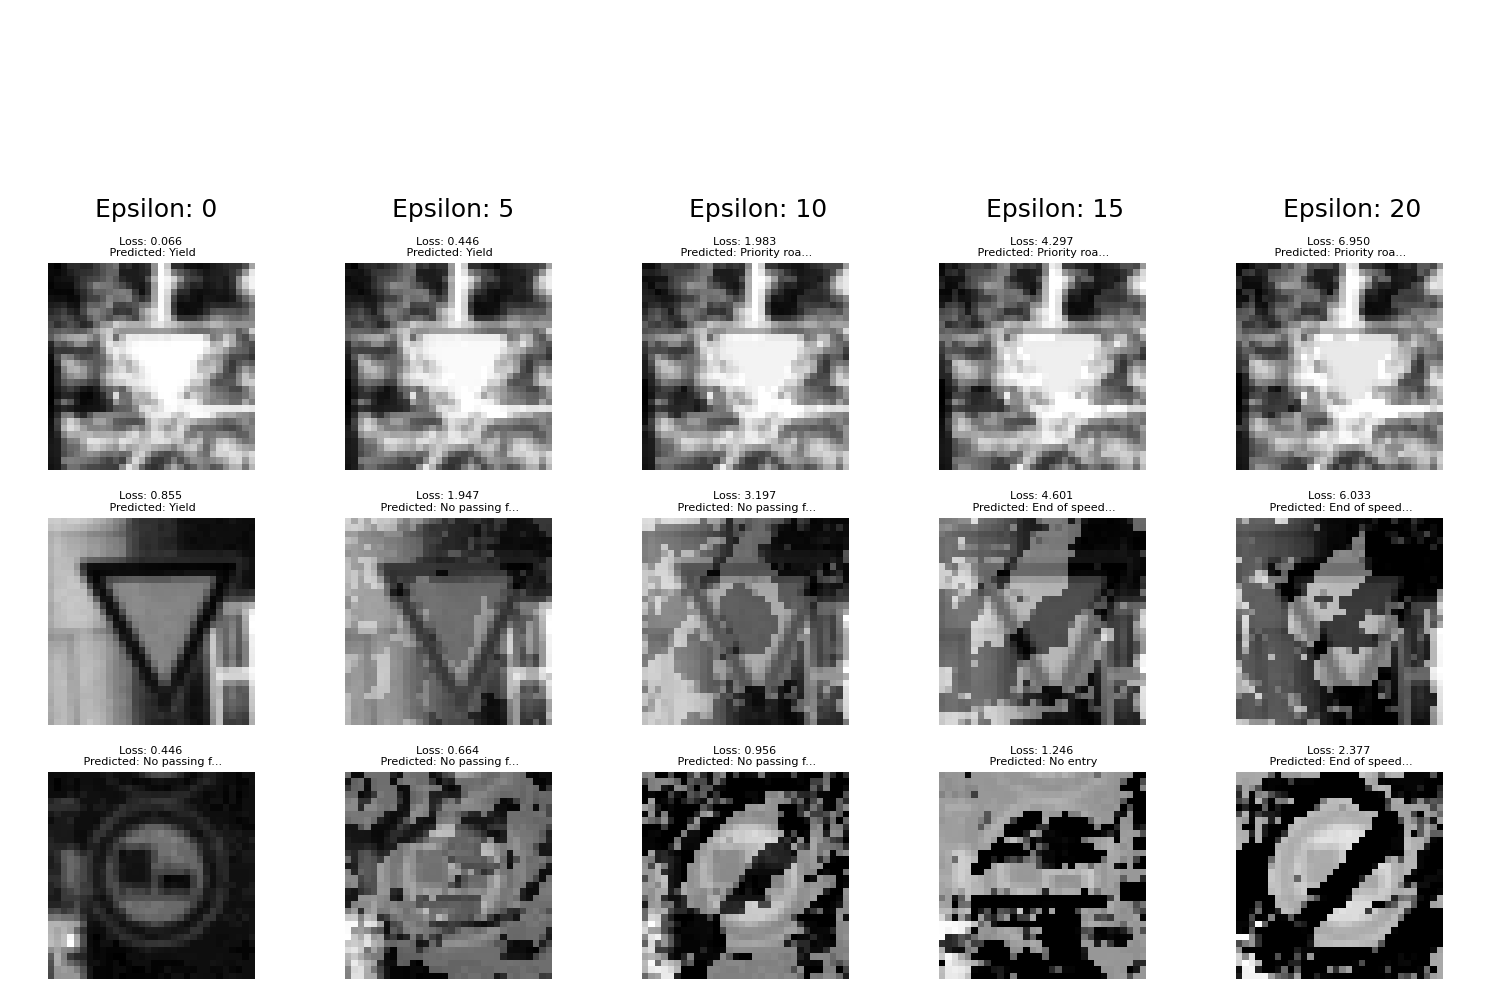

In [53]:
adversarial_test(adversarial_model)

In [55]:
save_model(adversarial_model,f"adversarial_{epsilon:.3f}")

Saving models/adversarial_0.039.pth
